In [1]:
%env LIRAS_PATH=/old/projects/LIRAS/Development/liras
%load_ext autoreload
%autoreload 2
from mcrf.utils.setup_notebook import *
from netCDF4 import Dataset
from mcrf.liras import liras_path
from mcrf.liras.results import get_reference_data

env: LIRAS_PATH=/old/projects/LIRAS/Development/liras


/home/simonpf/build/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Loading ARTS API from: /home/simonpf/build/arts_fast/src/libarts_api.so


In [2]:
reference = get_reference_data(scene = "a", i_start = 2800, i_end = 3600)

/home/simonpf/src/parts/parts/scattering/psd/my05.py:207: RuntimeWarning: divide by zero encountered in true_divide
  / gamma((nu + 1) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:207: RuntimeWarning: invalid value encountered in true_divide
  / gamma((nu + 1) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:279: RuntimeWarning: divide by zero encountered in power
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:279: RuntimeWarning: invalid value encountered in multiply
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/d14.py:412: RuntimeWarning: invalid value encountered in true_divide
  dm = m4 / m3
/home/simonpf/src/parts/parts/scattering/psd/d14.py:414: RuntimeWarning: invalid value encountered in true_divide
  n0 = 4.0 ** 4 / (np.pi * self.rho) * md / dm ** 4


In [3]:
observations = Dataset(os.path.join(liras_path, "data", "forward_simulations_a_noise.nc"))
y_ici  = observations["y_ici"][:]
y_mwi  = observations["y_mwi"][:]
y_lcpr = observations["y_lcpr"][:]

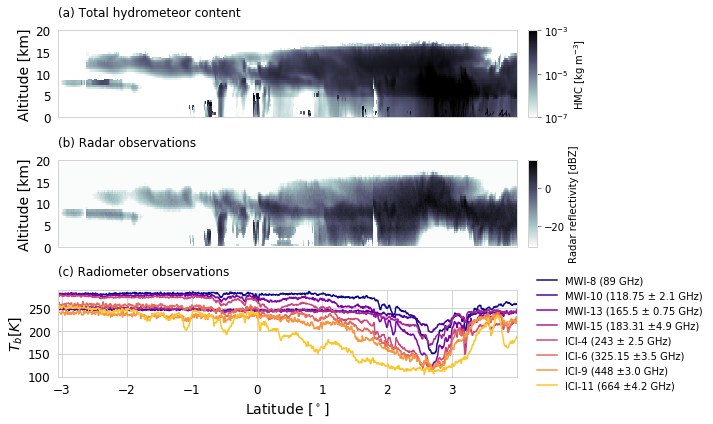

In [6]:
from mcrf.sensors import lcpr
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import bone_r, plasma

f = plt.figure(figsize = (10, 6))
gs = GridSpec(3, 2, width_ratios = [1.0, 0.02])

#
# Hydrometeor mass density
#

ax = plt.subplot(gs[0, 0])
norm = LogNorm(1e-7, 1e-3)

x = reference["lat"]
y = reference["z"] / 1e3
z = sum([reference[q][:] for q in ["iwc", "swc", "gwc", "hwc", "rwc", "lwc"]])
img = ax.pcolormesh(x, y, z.T, cmap = bone_r, norm = norm)

ax.set_ylabel("Altitude [km]", fontsize = 14)
ax.set_ylim([0, 20])
ax.set_xticklabels([])
ax.set_title("(a) Total hydrometeor content", loc = "left", fontsize = 12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
ax = plt.subplot(gs[0, 1])
cbar = plt.colorbar(img, cax = ax, label = "HMC [kg m$^{-3}$]")
cbar.ax.xaxis.label.set_fontsize(14)
cbar.ax.tick_params(labelsize=10) 

#
# Active
#

ax = plt.subplot(gs[1, 0])
y = lcpr.range_bins
y = 0.5 * (y[1:] + y[:-1]) / 1e3
img = ax.pcolormesh(x, y, y_lcpr.T, cmap = bone_r)
ax.xaxis.set_visible(False)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

ax.set_title("(b) Radar observations", loc = "left", fontsize = 12)
ax.set_ylabel("Altitude [km]", fontsize = 14)
ax.set_ylim([0, 20])
ax.set_xticklabels([])
cbar.ax.tick_params(labelsize=10) 

ax = plt.subplot(gs[1, 1])
cbar = plt.colorbar(img, cax = ax, label = "Radar reflectivity [dBZ]")
cbar.ax.xaxis.label.set_fontsize(14)
cbar.ax.tick_params(labelsize=10) 

#
# Passive
#

mwi_indices = [0, 2, 5, 6]
ici_indices = [3, 5, 8, 10]

n = len(mwi_indices) + len(ici_indices)
cs = plasma(np.arange(n) / n)

ax = plt.subplot(gs[2, 0])
handles = []
for i, j in enumerate(mwi_indices):
    handles += ax.plot(x, y_mwi[:, j], c = cs[i])
for i, j in enumerate(ici_indices):
    handles += ax.plot(x, y_ici[:, j], c = cs[i + len(mwi_indices)])
ax.set_title("(c) Radiometer observations", loc = "left", fontsize = 12)
ax.set_ylabel("$T_b [K]$", fontsize = 14)
ax.set_xlabel("Latitude [$^\circ$]", fontsize = 14)
ax.set_xlim([x[0], x[-1]])
ax.set_ylim([100, 290])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

labels = ["89 GHz", "118 ± 2.1 GHz", "165 ± 0.75 GHz", "185 ± 3.4 GHz",
          "243 ± 2.5 GHz", "325 ± 3.5 Ghz", "448 ± 3.0 GHz", "664 ± 4.2 GHz"]
labels = ["MWI-8 (89 GHz)", "MWI-10 (118.75 ± 2.1 GHz)", "MWI-13 (165.5 ± 0.75 GHz)", "MWI-15 (183.31 ±4.9 GHz)"]
labels += ["ICI-4 (243 ± 2.5 GHz)", "ICI-6 (325.15 ±3.5 GHz)",
           "ICI-9 (448 ±3.0 GHz)", "ICI-11 (664 ±4.2 GHz)"]
ax = plt.subplot(gs[2, 1])
ax.legend(handles = handles, labels = labels, loc = "center left", fontsize = 10)
ax.axis("off")

plt.tight_layout()
f.savefig("../../../plots/observations_a.png", bbox_inches = "tight", dpi = 300)